In [64]:
from modAL import batch
from modAL.models import ActiveLearner
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from functools import partial
from typing import Union, Tuple

In [75]:
def active_split(X, Y, shuffle=True):
    """
    Split data into three sets:
    * Labeled training set (0.1)
    * Unlabeled training set, to be queried (0.4)
    * Labeled test set (0.5)
    """

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, shuffle=shuffle)
    X_labelled, X_unlabelled, Y_labelled, Y_oracle = train_test_split(X_train, Y_train, test_size=0.9, shuffle=shuffle)

    return X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test

def active_learn(X, y, query_strategy) -> Tuple[list, list]:
    """
    Perform active learning on the given dataset using a linear SVM model, querying data with the given query strategy.

    Returns the accuracy curve.
    """
    X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test = active_split(X, y, shuffle=False)
    learner = ActiveLearner(
        estimator=svm.SVC(kernel='linear', probability=True), 
        X_training=X_labelled, 
        y_training=Y_labelled, 
        query_strategy=query_strategy
    )

    trained = [len(X_labelled)]
    accuracy = [learner.score(X_test, Y_test)]
    while len(X_unlabelled) != 0:
        query_idx, _ = learner.query(X_unlabelled)
        learner.teach(X_unlabelled[query_idx], Y_oracle[query_idx])
        X_unlabelled = np.delete(X_unlabelled, query_idx, axis=0)
        Y_oracle = np.delete(Y_oracle, query_idx, axis=0)
        trained.append(trained[-1]+10)
        accuracy.append(learner.score(X_test, Y_test))
    return (trained, accuracy)


In [70]:
def random_batch(
    classifier: sklearn.base.BaseEstimator, 
    X: Union[list, np.ndarray, scipy.sparse.csr.csr_matrix], 
    n_instances: int = 1, 
    random_tie_break: bool = False, 
    **uncertainty_measure_kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    idx = np.random.choice(X.shape[0], n_instances)
    return (idx, X[idx])

In [3]:
digits = datasets.load_digits()

In [4]:
# Reshape
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

In [48]:
X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test = active_split(data, digits.target, shuffle=False)

In [49]:
confidence_learner = ActiveLearner(estimator=svm.SVC(kernel='linear', probability=True), X_training=X_labelled, y_training=Y_labelled, query_strategy=partial(batch.uncertainty_batch_sampling, n_instances=10))


In [50]:
confidence_trained = [len(X_labelled)]
confidence_accuracy = [confidence_learner.score(X_test, Y_test)]
while len(X_unlabelled) != 0:
    query_idx, _ = confidence_learner.query(X_unlabelled)
    confidence_learner.teach(X_unlabelled[query_idx], Y_oracle[query_idx])
    X_unlabelled = np.delete(X_unlabelled, query_idx, axis=0)
    Y_oracle = np.delete(Y_oracle, query_idx, axis=0)
    confidence_trained.append(confidence_trained[-1]+10)
    confidence_accuracy.append(confidence_learner.score(X_test, Y_test))

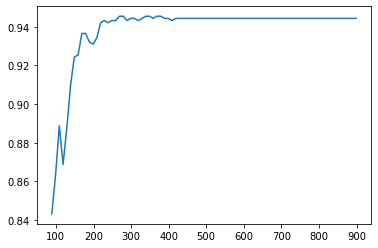

In [51]:
plt.plot(confidence_trained, confidence_accuracy);

In [71]:
uncertainty_results = active_learn(data, digits.target, partial(batch.uncertainty_batch_sampling, n_instances=10))
random_results = active_learn(data, digits.target, partial(random_batch, n_instances=10))

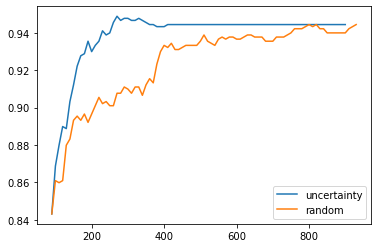

In [74]:
plt.plot(uncertainty_results[0], uncertainty_results[1], label="uncertainty")
plt.plot(random_results[0], random_results[1], label="random")
plt.legend();